---
title: "Gumbel Softmax trick"
description: "A trick to enable gradient-based optimization over discrete choices."
date: 2025-07-04
categories: [deep learning, differentiable programming, reparameterization]
format: html
execute: 
  enabled: True
---

#### Can You Backprop Through a Discrete Choice?
Suppose your model must choose one of several categories say, Red, Green, or Blue.

You use `argmax` or sample from a categorical distribution.
But then how do you backpropagate?

#### Answer: You can’t.
But you can cheat slightly and still train using the Gumbel-Softmax trick.

#### The Problem: argmax Breaks Gradients

```python
import torch
import torch.nn.functional as F

logits = torch.tensor([[2.0, 1.0, 0.1]], requires_grad=True)
probs = F.softmax(logits, dim=-1)
sample = torch.argmax(probs, dim=-1)

loss = sample.float().sum()
loss.backward()  #  Throws an error
```

### 🧙‍♂️ The Magic Behind Gumbel-Softmax

Okay, you want your model to pick one option out of many. But you still want to train it with backprop?

Most people try this:

```python
choice = torch.argmax(logits, dim=-1)  # ❌ Not differentiable
```

##### Boom. Backprop dies.
Gradients have no idea how to flow through that hard decision.

*So what if instead of a hard choice we pretend to choose using a soft, trainable mask?*

That’s exactly what the Gumbel-Softmax trick does.

In [1]:
import torch
import torch.nn.functional as F

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax(logits, tau=1.0):
    g = sample_gumbel(logits.shape)
    return F.softmax((logits + g) / tau, dim=-1)


* logits are your unnormalized preferences

* g is random Gumbel noise added to shake things up

* tau is the temperature, controls how sharp or soft the final decision is

* Softmax turns the noisy preferences into a smooth probability vector

As tau → 0
The softmax becomes sharper, and the output becomes almost one-hot like a discrete decision!

**Visual Example:** Learn to Blend Colors
Let’s say your model needs to pick one color — Red, Green, or Blue — to match a target color (like purple 💜).

But instead of making a hard choice, it learns to blend the colors using Gumbel-Softmax.

In [2]:
import torch
# Our palette
palette = torch.tensor([
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0]   # Blue
])

# Trainable selection logits
logits = torch.nn.Parameter(torch.randn(1, 3))

# Our target is purple (red + blue)
target = torch.tensor([[0.5, 0.0, 0.5]])

opt = torch.optim.Adam([logits], lr=0.1)


In [3]:
losses = []

for step in range(100):
    opt.zero_grad()
    probs = gumbel_softmax(logits, tau=0.5)
    color = probs @ palette  # Weighted blend
    loss = F.mse_loss(color, target)
    losses.append(loss.item())
    loss.backward()
    opt.step()

    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss.item():.4f}")


Step 0: Loss = 0.0004
Step 10: Loss = 0.1203
Step 20: Loss = 0.1596
Step 30: Loss = 0.1646
Step 40: Loss = 0.1624
Step 50: Loss = 0.0030
Step 60: Loss = 0.1530
Step 70: Loss = 0.1413
Step 80: Loss = 0.1666
Step 90: Loss = 0.0225


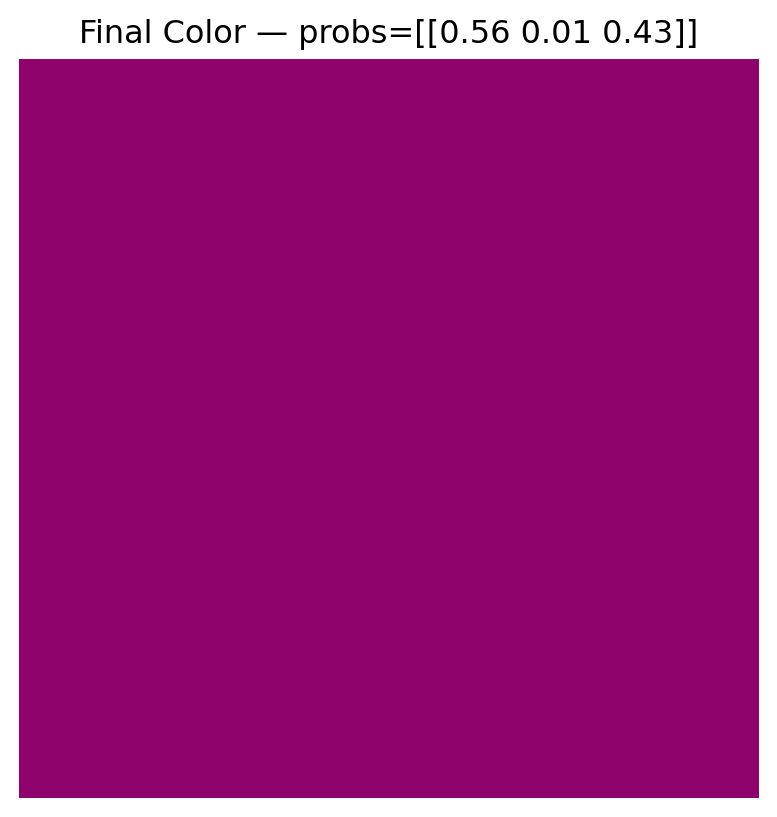

In [4]:
import matplotlib.pyplot as plt
with torch.no_grad():
    probs = F.softmax(logits, dim=-1)
    blended = probs @ palette

    plt.imshow(blended.view(1, 1, 3).numpy())
    plt.title(f"Final Color — probs={probs.numpy().round(2)}")
    plt.axis('off')
    plt.show()


#### **Boom!** The model learns a soft mix of red and blue to match the purple target.

#### *Even though it’s choosing among discrete categories, it’s doing it in a way that’s smooth and differentiable.*

Some reading material: [Arxiv Link](https://arxiv.org/pdf/1611.01144)